In [29]:
# 1. Importing Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier



In [30]:
# 2. Load and Prepare Data
data = pd.read_csv("cleaned_multiclass_diabetes_dataset.csv")  # Replace with your path
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# 3. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Feature Scaling
scaler = StandardScaler()
# Scale and retain feature names
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)



In [31]:
#remve nan 
X_train_scaled = np.nan_to_num(X_train_scaled)
#remve nan
X_test_scaled = np.nan_to_num(X_test_scaled)

In [32]:
print("size of X_train_scaled:", X_train_scaled.shape)
print("size of X_test_scaled:", X_test_scaled.shape)

size of X_train_scaled: (211, 11)
size of X_test_scaled: (53, 11)


In [33]:
print(y_train.value_counts())

Class
2    101
0     78
1     32
Name: count, dtype: int64


In [34]:
# 5. Try Multiple Models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier()
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")


Logistic Regression Accuracy: 0.8868
Decision Tree Accuracy: 0.9811
SVM Accuracy: 0.9245
Random Forest Accuracy: 0.9811
KNN Accuracy: 0.9057



Best Model: Decision Tree
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       0.89      1.00      0.94         8
           2       1.00      1.00      1.00        27

    accuracy                           0.98        53
   macro avg       0.96      0.98      0.97        53
weighted avg       0.98      0.98      0.98        53



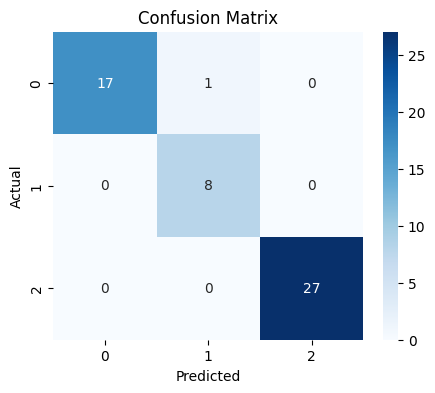

In [35]:
# 6. Model Evaluation (Best Model)
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:,1] if hasattr(best_model, "predict_proba") else None

print("\nBest Model:", best_model_name)
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve (if binary)
if y_proba is not None and len(np.unique(y)) == 2:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{best_model_name} (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()


In [36]:
# 7. Model Improvement (Example: GridSearchCV for Random Forest)
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print("\nGrid Search Best Params:", grid.best_params_)
print("Best Score from GridSearchCV:", grid.best_score_)

# Re-evaluate on Test Set
best_rf = grid.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
print("\nImproved RF Accuracy:", accuracy_score(y_test, y_pred_rf))


Grid Search Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best Score from GridSearchCV: 0.9287929125138428

Improved RF Accuracy: 0.9811320754716981


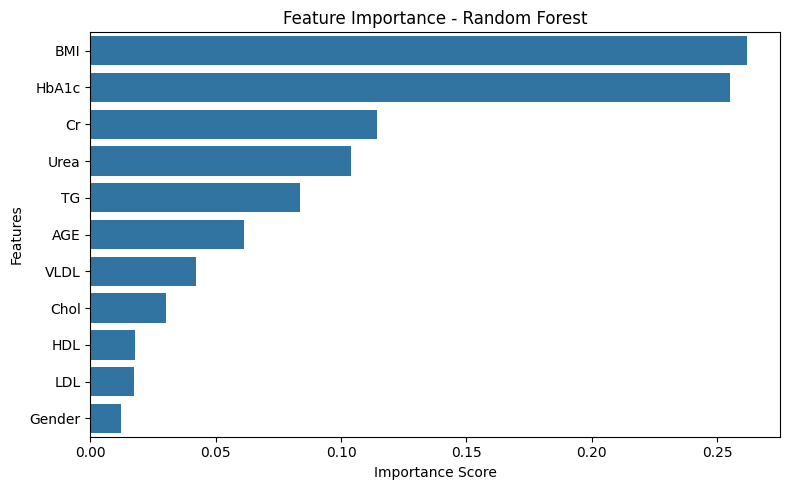

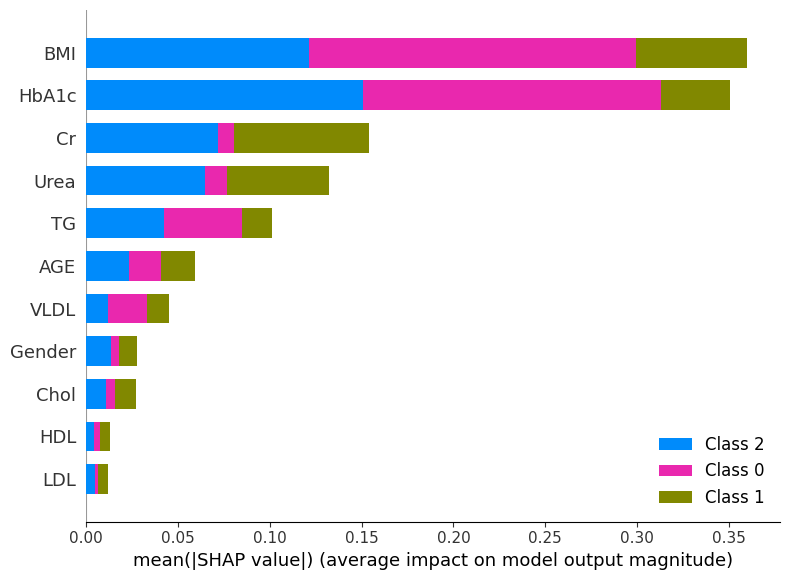

In [ ]:

importances = best_rf.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

import shap

# Create explainer using scaled data (because model was trained on it)
explainer = shap.Explainer(best_rf, X_train_scaled)

# Wrap test data in DataFrame to retain feature names
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Compute SHAP values (disable strict check)
shap_values = explainer(X_test_scaled_df, check_additivity=False)

# Global Explanation - Summary Bar Plot
shap.summary_plot(shap_values, X_test_scaled_df, plot_type="bar")



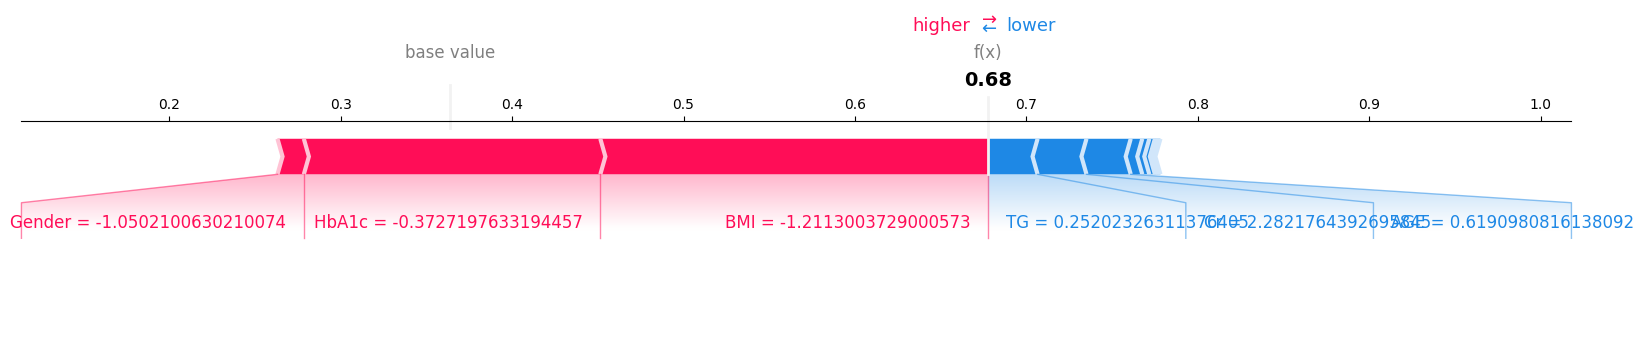

In [ ]:
# For multiclass, select the first sample and class 0
shap.plots.force(
	shap_values.base_values[0, 0],          # base value for sample 0, class 0
	shap_values.values[0, :, 0],            # SHAP values for sample 0, class 0
	X_test_scaled_df.iloc[0],               # feature values for sample 0
	matplotlib=True
)